In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from analyzeradprofile import *
from fitellipse import *

In [2]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/Elias27_lowgain.image.fits',
                          'distance':116,
                          'incl' : 57.2,
                          'PA' : 118.4,
                          'offsetx' : -.002,
                          'offsety' : -.002,
                          'size': 4,
                          'gamma': 0.5
                         }
maxrad = 250
radialbins = 1+2*np.arange(125)

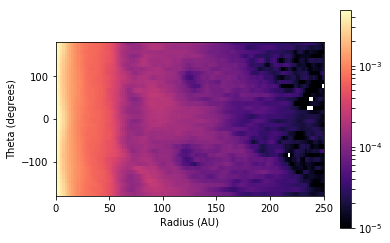

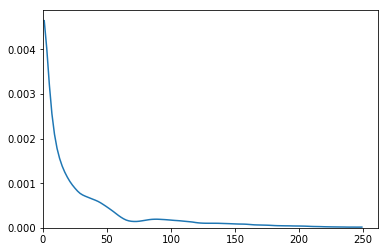

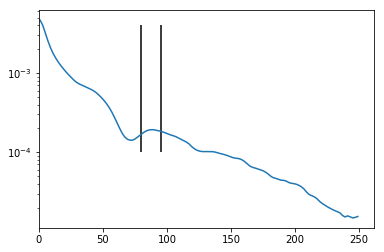

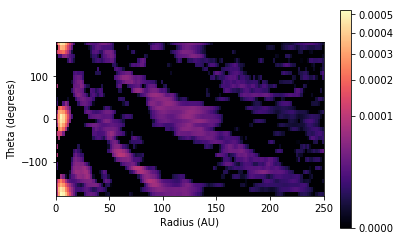

In [24]:


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])

surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
#           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = 0.4))\
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.LogNorm(vmin = 1.e-5))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.vlines(80, 1.e-4, .004)
plt.vlines(95,1.e-4,.004)
plt.xlim(xmin = 0)
plt.show()

plt.imshow(rtmap-surfbrightness,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()



The MLE offsets are delta_x = -5.190e-03 arcsec, delta_y = -7.623e-03 arcsec
The MLE semi-major axis is r = 0.596 arcsec
The MLE inclination is i = 56.220 degrees
The MLE position angle is PA = 118.767 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.492e+00


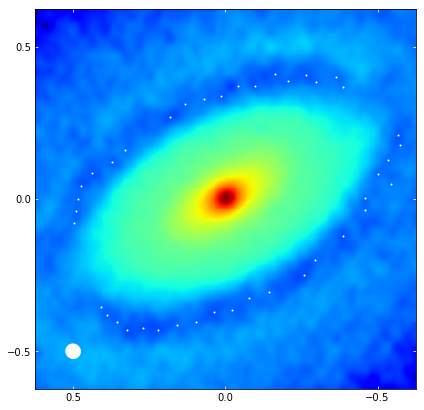

In [20]:


# Extract the gap that's at ~70 AU
#xcoords1, ycoords1 = cont.extract_ring(65,75,
#                                       tbins = np.concatenate((-177+6*np.arange(11),  -88+6*np.arange(27),123+6*np.arange(10))),
#                                                                     extract_type = 'min')

xcoords1, ycoords1 = cont.extract_ring(65,75,
                                       tbins = np.concatenate((-177+6*np.arange(11),  -76+6*np.arange(25),123+6*np.arange(10))),
                                                                     extract_type = 'min')
cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 1.25, cmap = 'jet')

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     70/116.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)


In [25]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and 0<cosi<1 and 0 < par < np.pi and -15<logvar<-5:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

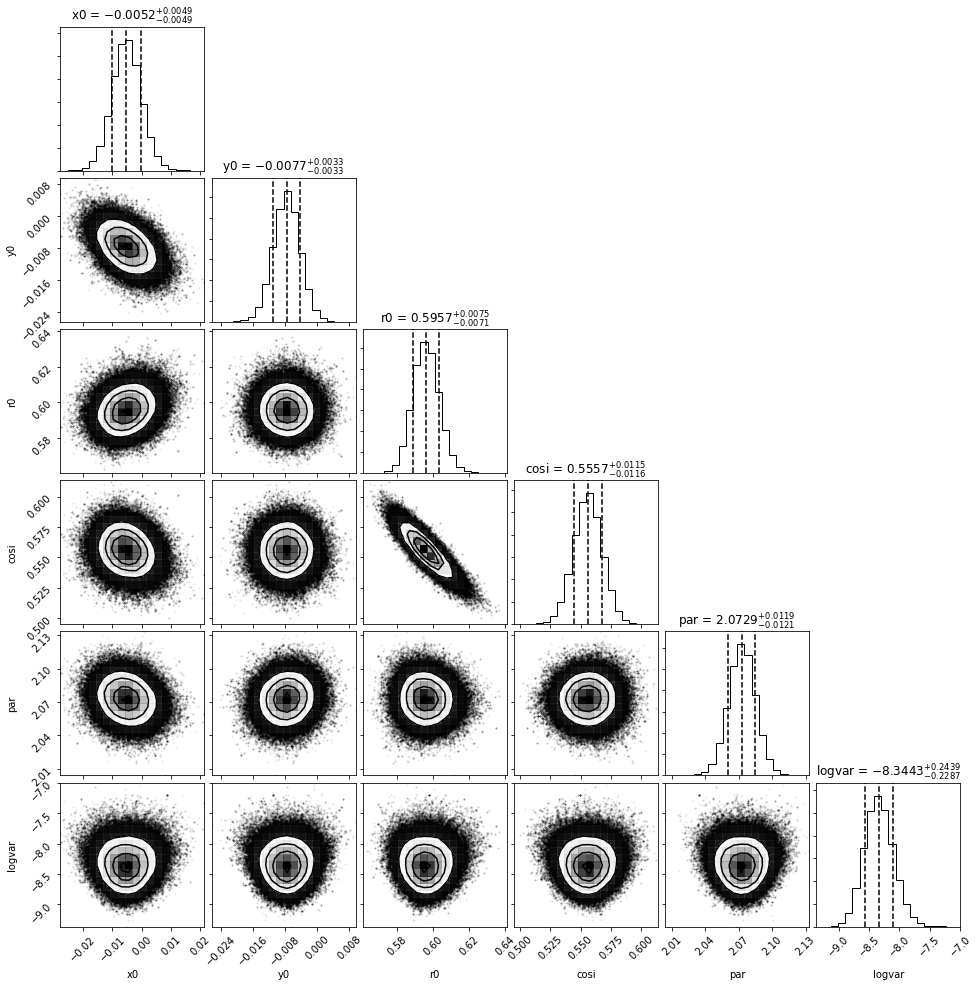

The x offset is delta_x = -5.19e-03 arcsec (+4.9e-03, -4.9e-03)
The y offset is delta_y = -7.66e-03 arcsec (+3.3e-03, -3.3e-03)
The median semi-major axis is r = 0.5957 arcsec (+0.0075, -0.0071) 
or 69.11 AU (+0.38, -0.39)
The incl is i = 56.24 deg (+0.79, -0.80)
The median position angle is PA = 118.77 deg (+0.68, -0.69)
The median log-variance in the pixel offsets from the true ellipse is -8.344e+00


In [26]:


plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)


In [ ]:
np.savez("Elias27ellipsechains.npz", DA70 = sampler1.chain)

In [3]:

maxrad = 250
radialbins = 0.5+np.arange(0, maxrad)
#make some preliminary plots
newcont = Continuum(disk['filename'], -0.0052,-0.0077, 118.8, 56.2,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

('max', [86, 128, 233, 240])
('min', [70, 127, 232, 238, 245])


/home/janehuan/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


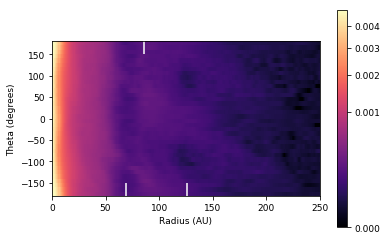

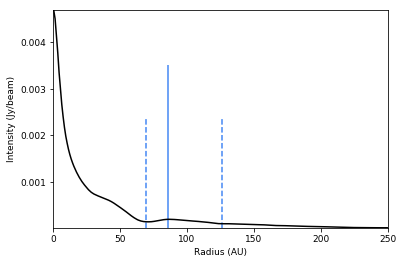

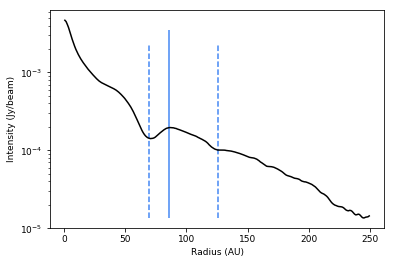

(0, 250)

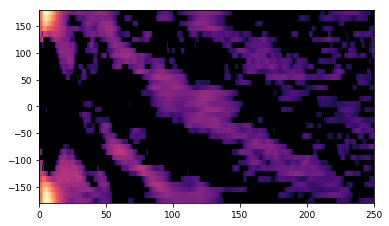

In [4]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
gaps = np.array([69.1, 126])
rings = np.array([86])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)


In [5]:
calc_contrast(69.1, 86.001, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.72807833990423254, 0.02213731053745354)

In [6]:
measure_widths(69.1, 86.001, radialbins, newsurfbrightness, 0, 125)

(0.00016952417429942222, 78.799999999999983)


(14.299999999999997, 21.199999999999989)

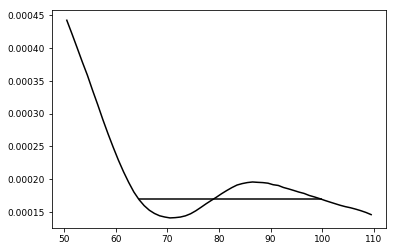

In [8]:
plt.plot(radialbins[50:110], newsurfbrightness[50:110], color = 'black')
plt.hlines(0.00016952417429942222, 78.8-14.3,78.8)
plt.hlines(0.00016952417429942222, 78.8,78.8+21.2)

253.5


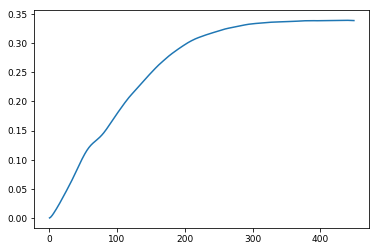

In [9]:
bins = 0.5+1*np.arange(0, 450)

cumeflux = newcont.cumefluxprofile(bins)

plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])